In [1]:
import ee
from drought.data import ee_climate, pipeline
from drought.visualization import plot
import geemap
import matplotlib.pyplot as plt
import pandas as pd
import importlib

## Prerequisites

Before running the notebook, make sure to authenticate with Google Earth 
Engine. 

You can do so by running ```earthengine authenticate``` on the command line
or uncommenting the authentication cell below. See [here](https://developers.google.com/earth-engine/guides/python_install#authentication) for more details.

### Earth Engine Initialization

In [ ]:
# Uncomment if you want to authenticate within jupyter notebook.
ee.Authenticate()

In [2]:
ee.Initialize()

## Get Climate Data

In [3]:
# Dates of interest.
start_date = ee.Date('2019-01-01')
end_date = ee.Date('2023-01-01')

# Get regions of interest.
ee_geoms = pipeline.get_ee_polygons()

# Specify resolution.
scale = 5000

# Fetch climate data from Earth Engine as Pandas DataFrame.
climate_monthly_pdf = ee_climate.get_monthly_climate_data_as_pdf(
        start_date, end_date, ee_geoms, scale)

### Plot total monthly averages

In [5]:
# Calculate monthly mean for all three years in aggregate.
total_monthly_mean = climate_monthly_pdf.groupby(['month', 'polygon_id']) \
                                .mean(numeric_only=True).reset_index() \
                                .drop(columns=['year'])

In [ ]:
# Palette for plotting. Colors can be accessed by indexing - plot.palette[i]
plot.palette

In [ ]:
# Plot aggregate monthly precipitation per region.
fig = plot.barplot_per_polygon(total_monthly_mean,
                              x='month', 
                              y='precipitation', 
                              ylabel="Precipitation mm / month",
                              title="Aggregate monthly precipitation per region 2019-2022",
                              color=plot.palette[5])
# Mark the 100mm precipitation line that signifies a dry month.
[subplot.axhline(y=100, color = 'r', linestyle = 'dotted', linewidth=3) 
 for subplot in fig.get_axes()]
plt.show()

In [ ]:
# Plot aggregate monthly radiation per region.
fig = plot.barplot_per_polygon(total_monthly_mean,
                              x='month', 
                              y='radiation', 
                              ylabel="Radiation",
                              title="Mean monthly radiation per region 2019-2022",
                              color=plot.palette[0],
                              sharey=True)
plt.show()

In [ ]:
# Plot aggregate monthly temperature per region.
fig = plot.barplot_per_polygon(total_monthly_mean,
                              x='month', 
                              y='temperature', 
                              ylabel="Temperature",
                              title="Mean monthly temperature per region 2019-2022",
                              color=plot.palette[7],
                              sharey=True)
plt.show()

In [ ]:
# Plot aggregate monthly fpar per region.
fig = plot.barplot_per_polygon(total_monthly_mean,
                              x='month', 
                              y='fpar', 
                              ylabel="Fpar",
                              title="Mean monthly Fpar per region 2019-2022",
                              color=plot.palette[3],
                              sharey=True)
plt.show()

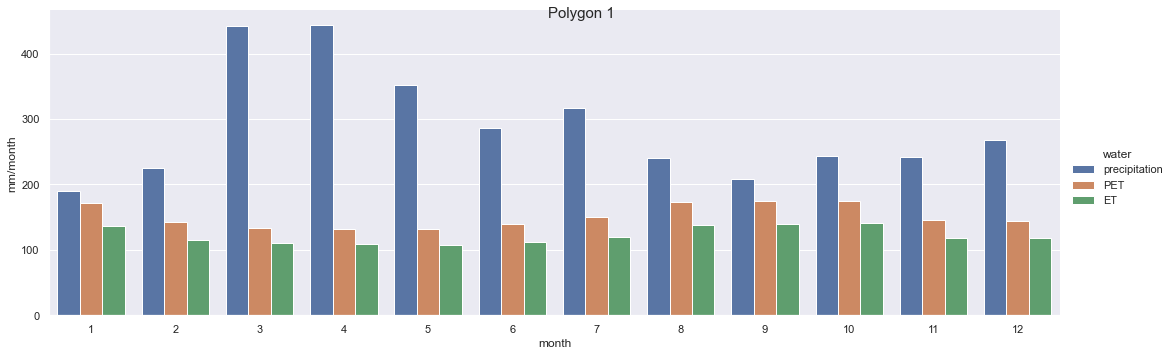

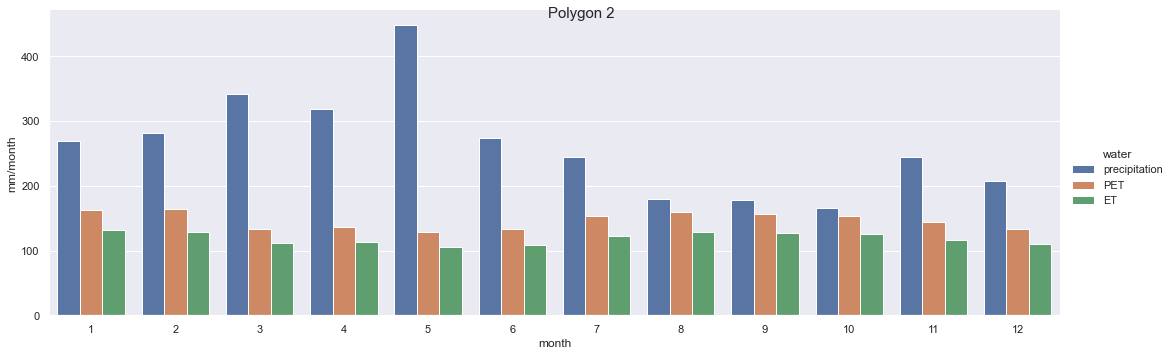

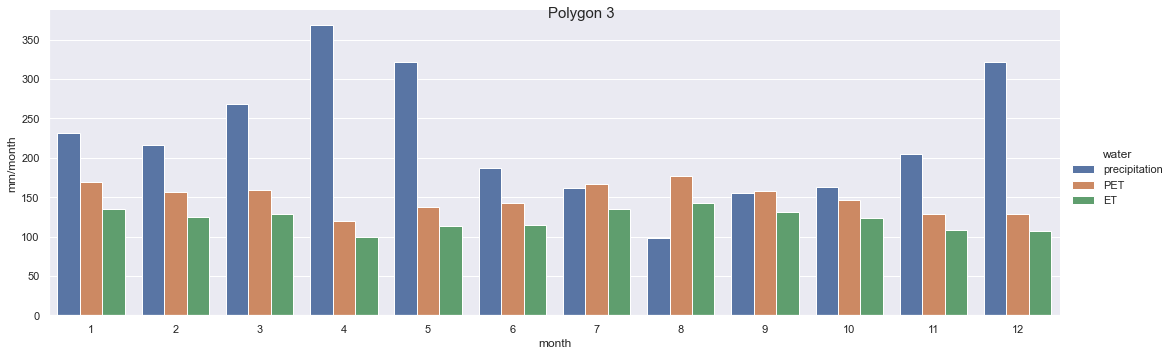

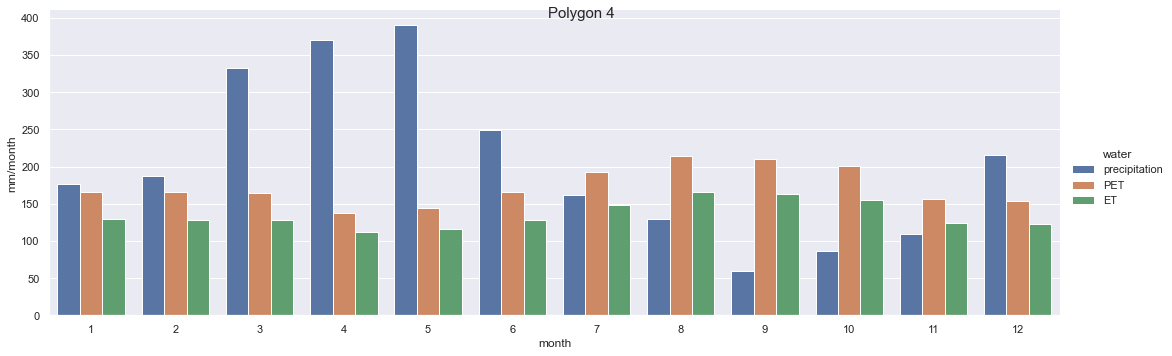

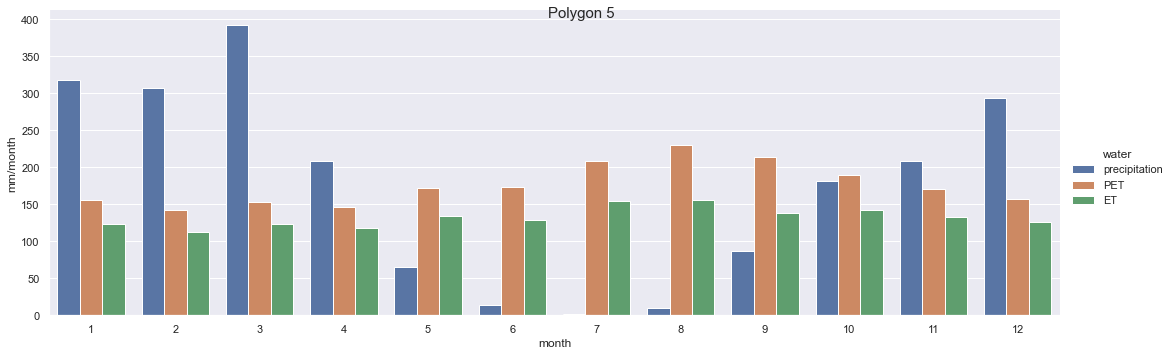

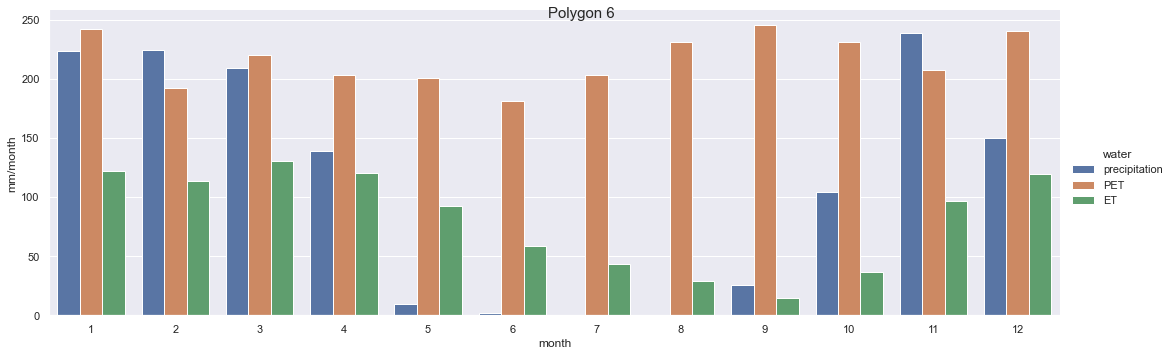

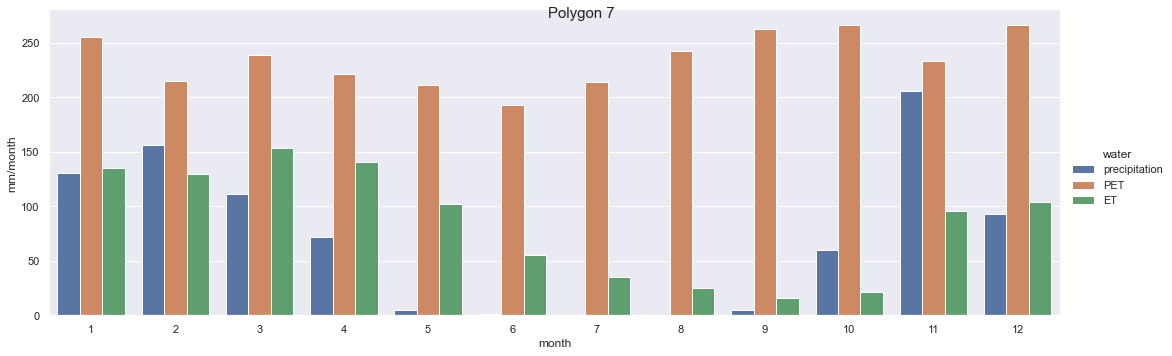

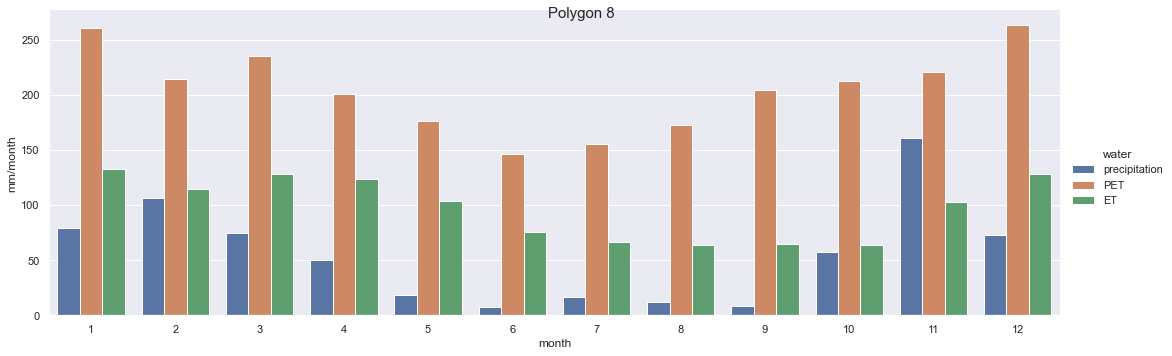

In [7]:
fig = plot.catplot_per_polygon(total_monthly_mean, 'month', 'mm/month', 'water', 'bar', ['precipitation', 'PET', 'ET'], title="bla")
plt.show()

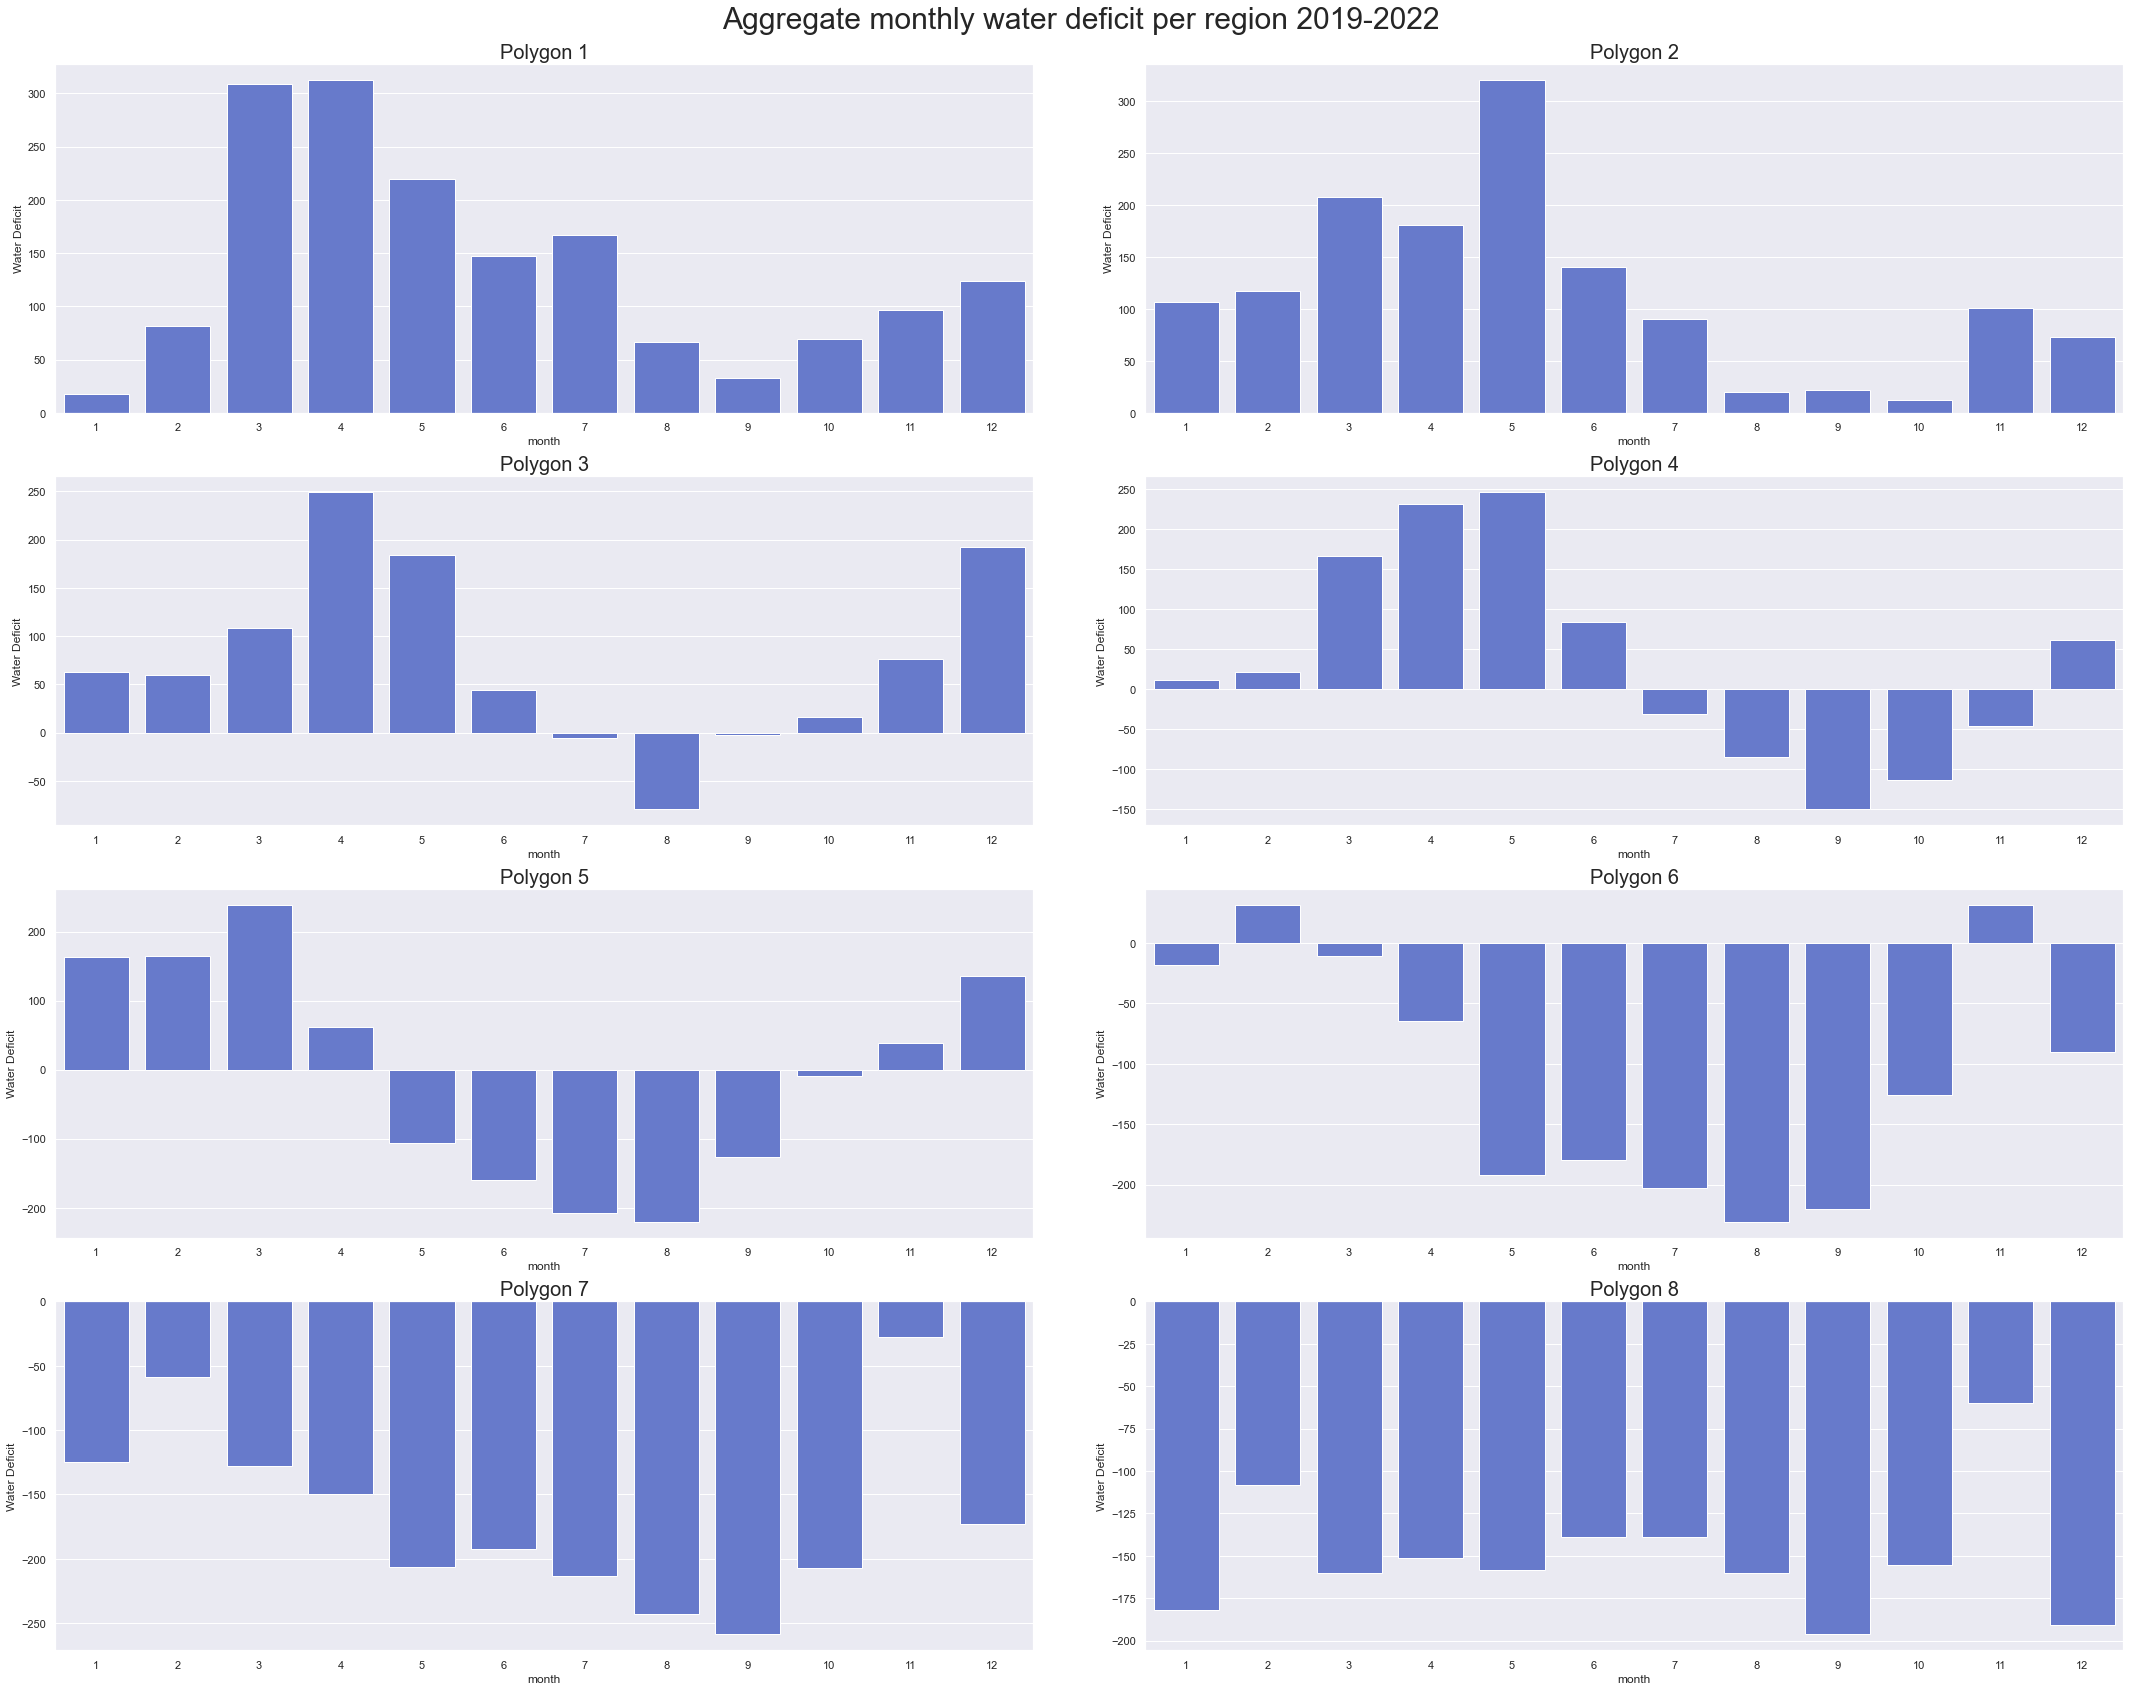

In [6]:
# Water deficit
total_monthly_mean['water_deficit'] = total_monthly_mean['precipitation'] - total_monthly_mean['PET']
# Plot aggregate monthly potential evapotranspiration per region.
fig = plot.barplot_per_polygon(total_monthly_mean,
                              x='month', 
                              y='water_deficit', 
                              ylabel="Water Deficit",
                              title="Aggregate monthly water deficit per region 2019-2022",
                              color=plot.palette[5])

plt.savefig(f'../../reports/figures/exploratory/total_monthly_water_deficit_2019_to_2022.png')
plt.show()

### Fetch and Save Climate Data for 2010-2022

In [2]:
# Dates of interest.
start_date_str = '2010-01-01'
end_date_str = '2022-11-01'

In [ ]:
# Dates of interest.
start_date = ee.Date(start_date_str)
end_date = ee.Date(end_date_str)

# Get regions of interest.
ee_geoms = pipeline.get_ee_polygons()

# Specify resolution.
scale = 5000

# NOTE: we partitioned the data fetch in two because otherwise we go over
# the Earth Engine limit, so we need to chunk.

# Fetch water-related variables.
precip_df = ee_climate.get_monthly_climate_data_as_pdf(
        start_date, end_date, ee_geoms, scale, columns=['precipitation', 'ET', 'PET'])

# Fetch other climate variables
radiation_pdf = ee_climate.get_monthly_climate_data_as_pdf(
        start_date, end_date, ee_geoms, scale, columns=['temperature', 'radiation', 'fpar'])

In [ ]:
precip_monthly_mean = precip_df.groupby(['month', 'polygon_id', 'year']) \
                               .mean(numeric_only=True).reset_index()
precip_monthly_mean = dfext.add_datetime_column(precip_monthly_mean)
precip_monthly_mean = dfext.add_date_column(precip_monthly_mean)
precip_monthly_mean['P-PET'] = precip_monthly_mean['precipitation'] - precip_monthly_mean['PET']
precip_monthly_mean['P-ET'] = precip_monthly_mean['precipitation'] - precip_monthly_mean['ET']

In [ ]:
radiation_monthly_mean = radiation_pdf.groupby(['month', 'polygon_id', 'year']) \
                                      .mean(numeric_only=True).reset_index()
radiation_monthly_mean = dfext.add_datetime_column(radiation_monthly_mean)
radiation_monthly_mean = dfext.add_date_column(radiation_monthly_mean)

In [ ]:
precip_monthly_mean.to_csv('../../data/interim/monthly_means_timeseries_of_water_climate_vars_01-2010_to_11-2022.csv')
radiation_monthly_mean.to_csv('../../data/interim/monthly_means_timeseries_of_radiation_vars_01-2010_to_11-2022.csv')

In [ ]:
# Join all climate vars.
climate_df = precip_monthly_mean.set_index(['month', 'polygon_id', 'year', 'datetime', 'date']) \
                                .join(radiation_monthly_mean.set_index(['month', 'polygon_id', 'year', 'datetime', 'date'])) \
                                .reset_index()

In [ ]:
climate_df.to_csv('../../data/interim/monthly_means_timeseries_of_climate_vars_01-2010_to_11-2022.csv')

### Fetch and Save Water Balance Data for 2001-2022

In [3]:
# Dates of interest.
start_date_str = '2001-01-01'
end_date_str = '2023-01-01'

In [ ]:
# Dates of interest.
start_date = ee.Date(start_date_str)
end_date = ee.Date(end_date_str)

# Get regions of interest.
ee_geoms = pipeline.get_ee_polygons()

# Specify resolution.
scale = 50000

# Fetch climate data from Earth Engine as Pandas DataFrame.
precip_df = ee_climate.get_monthly_climate_data_as_pdf(
        start_date, end_date, ee_geoms, scale, columns=['precipitation', 'PET'])

In [ ]:
precip_df.to_csv('../../data/interim/p_pet_2001-2023_scale_50km.csv')